# True Reach Estimator

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

## GroupBy Trial

In this trial we will first normalize each users data to their central tendancies before creating coefficiencies.

Given our eariler trials are producing varied results, we will attempt to group each variable to a central tendancie first. As Instagram's algorithm might produce highly varied results even among the same user, we beleive this process will help normalize against Instagrams algorithm and better predict a normal outcoume. 

Process: 
- Import the CSV
- Clean data
- View scatter plot of the data to check for better correlation.
- Create model on new data
- Test accuracy of a the model against the training data. 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

Pull in the CSV file

In [2]:
df = pd.read_csv('Impression-estimator-data.csv')

In [3]:
df.columns = ['user_id', 'instagram_id', 'followers', 'published', 'likes', 'comments', 'impressions', 'reach', 'saves']

First group the list by user_id with the means of each column.

In [4]:
df = df.groupby(df.user_id).mean().round()

In [5]:
df = df.reset_index()

In [6]:
df = df.drop(['user_id', 'saves'], axis=1)

In [7]:
df.head()

,followers,likes,comments,impressions,reach
0,100276.0,1472.0,69.0,6209.0,5302.0
1,10299.0,562.0,11.0,710.0,574.0
2,40025.0,1600.0,133.0,3371.0,2789.0
3,22071.0,807.0,34.0,11333.0,8932.0
4,24390.0,1467.0,76.0,6198.0,4824.0


In [8]:
len(df)

5093

## Create histograms of our three variables to check for normality. 

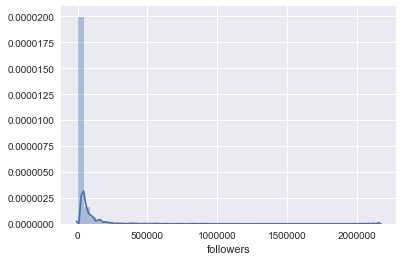

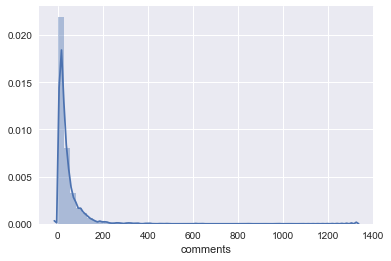

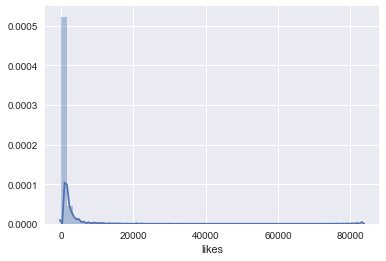

In [9]:
sns.distplot(df.followers)
plt.show()
sns.distplot(df.comments)
plt.show()
sns.distplot(df.likes)
plt.show()

## Remove users with very low data. 
It's probably a bot. This list consists of users consider influencers. Thus low follower counts, likes or reach is not likely in the data and those users are not ideal to create a model. 

In [10]:
# df = df[(df['reach']>5000)]

In [11]:
# df = df[(df['reach']<10000)]

We have decided to remove rows that have less than 300 followers. This not only helps eliminate outliers but in the data collection there were many rows with zero followers and high numbers in reach. This data clearly is not correct 

In [12]:
df = df[(df['followers']>300)]

Setting comments to greater than zero to avoid zero division errors

In [13]:
df = df[(df['comments']>=1)]

Remove rows with less than 100 likes to eliminate outliers.

In [14]:
df = df[(df['likes']>=100)]

Remove wierd situations where there are more comments or likes than reach.

In [15]:
df = df.loc[(df.likes<df.reach)]
df = df.loc[(df.comments<df.reach)]

Now, what does our data look like? 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3964 entries, 0 to 5087
Data columns (total 5 columns):
followers      3964 non-null float64
likes          3964 non-null float64
comments       3964 non-null float64
impressions    3964 non-null float64
reach          3964 non-null float64
dtypes: float64(5)
memory usage: 185.8 KB


# Multicollinearity Of Features
Next we look at full correlation. The test here is to make sure that any two of our variables aren't so correlated that the account for the same effect on the dependent variable.

In [17]:
df.corr()

,followers,likes,comments,impressions,reach
followers,1.000000,0.713230,0.429042,0.677758,0.670566
likes,0.713230,1.000000,0.582340,0.873042,0.854181
comments,0.429042,0.582340,1.000000,0.494374,0.485818
impressions,0.677758,0.873042,0.494374,1.000000,0.995593
reach,0.670566,0.854181,0.485818,0.995593,1.000000


We then created a heat map of the correation numbers to better see which variables we can use. 

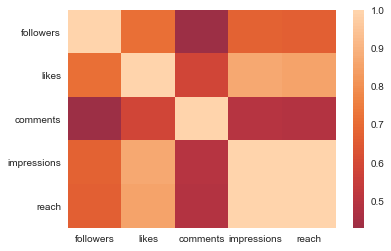

In [18]:
sns.heatmap(df.corr(), center=0);

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [19]:
lr_model = ols(formula='reach~followers + likes + comments', data=df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     3710.
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:01:51   Log-Likelihood:                -42635.
No. Observations:                3964   AIC:                         8.528e+04
Df Residuals:                    3960   BIC:                         8.530e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.8867    221.765      0.135      0.893    -404.897     464.671
followers      0.0334      0.003     10.795      0.000       0.027       0.040
likes          6.4839      0.108     60.151      0.000       6.273       6.695
comments      -6.8988      3.428     -2.013      0.044     -13.619      -0.179
==============================================================================
Omnibus:                     6296.297   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12337714.628
Skew:                           9.624   Prob(JB):                         0.00
Kurtosis:                     275.632   Cond. No.                     1.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Findings:** This model summary gives us promise. It is producing a very high r-squared value and our Y intercept is positive. However, the coefficients for the Comments feature is negative and could produce some less accurate results on outer ends of the scale.

## Scatterplots 
- Next we looked at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers Correlation plot')

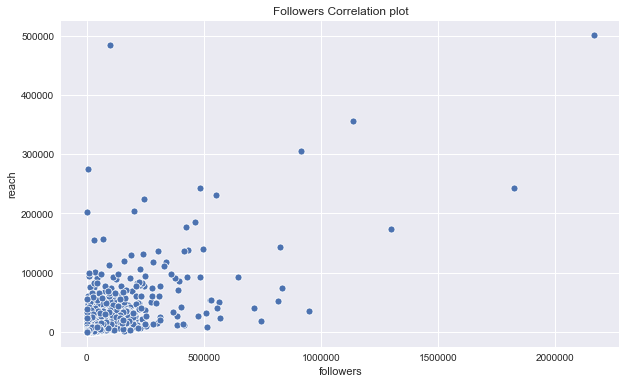

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df.followers, y=df.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")
# plt.xlim(0,75_000)
# plt.ylim(0, 1_000_000)

We find from this that there are outliers beyond 75,000 followers. 

Text(0.5, 1.0, 'Likes Correlation plot')

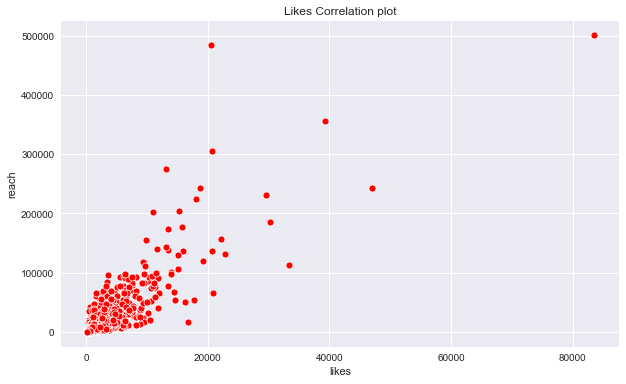

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df.reach, x=df.likes, color='red')
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

We find from this that there are outliers beyond 75,000 followers.

Text(0.5, 1.0, ' Comments Correlation plot')

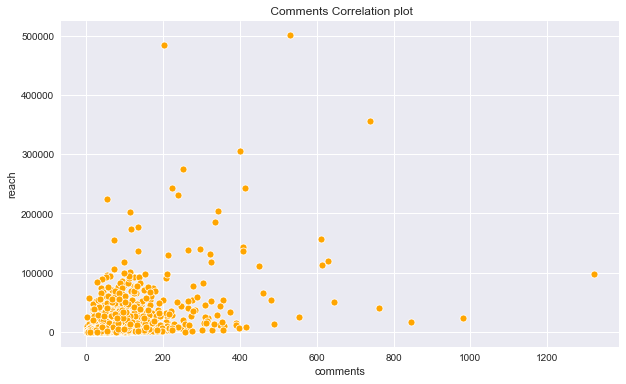

In [22]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df.reach, x=df.comments, color='orange')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

Based on the scatter plots we have decided to cut all users with more than 10,000 comments, 

## Remove extra large users. 

In [23]:
df = df[(df['followers']<75000)]
df = df[(df['likes']<75000)]
df = df[(df['comments']<10000)]

Now look at the data again to see if there are better stats. 

In [24]:
df.describe()  

,followers,likes,comments,impressions,reach
count,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000
mean,14588.242754,755.484671,38.450390,6420.027592,5058.042085
std,16454.569459,1100.612123,51.120269,13492.368809,10638.047734
min,301.000000,100.000000,1.000000,220.000000,165.000000
25%,2590.750000,232.000000,13.000000,1461.000000,1105.750000
50%,8536.000000,447.500000,25.000000,2840.500000,2216.500000
75%,20145.000000,873.000000,47.000000,6162.500000,4932.250000
max,74562.000000,22141.000000,1322.000000,358585.000000,275080.000000


Now that we have cut the top end outliers, Lets run the model and scatterplots again. 

Text(0.5, 1.0, 'Followers Correlation plot')

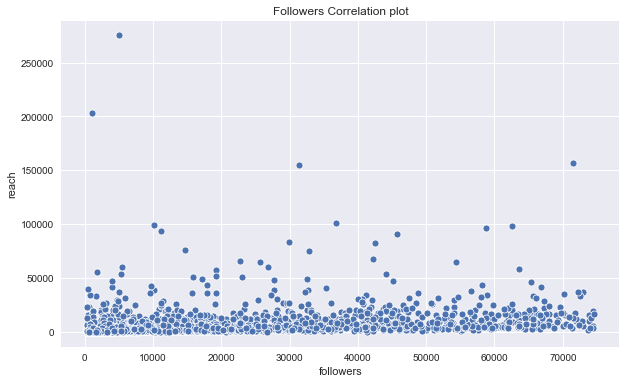

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df.followers, y=df.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")

Text(0.5, 1.0, 'Likes Correlation plot')

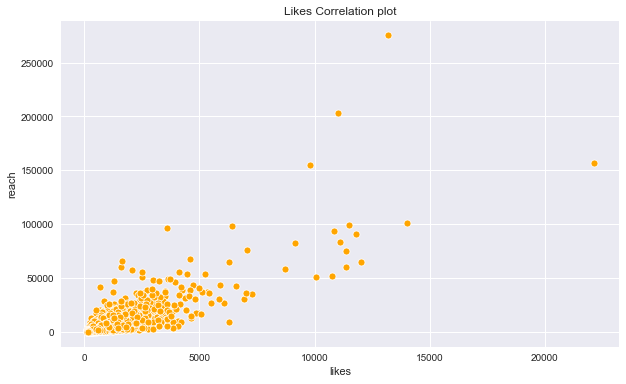

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df.reach, x=df.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

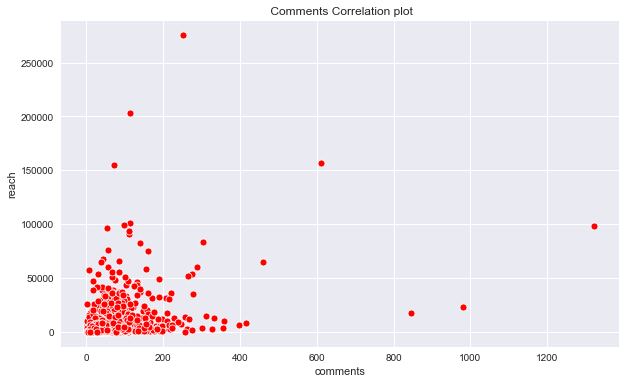

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df.reach, x=df.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

Create a test and train data set: 

In [28]:
# from sklearn.model_selection import train_test_split
# df, test = train_test_split(df, test_size=0.2)

In [29]:
abs(df.corr()) > 0.8

,followers,likes,comments,impressions,reach
followers,True,False,False,False,False
likes,False,True,False,True,True
comments,False,False,True,False,False
impressions,False,True,False,True,True
reach,False,True,False,True,True


Save clean CSV to new file for use on other notebooks.

In [30]:
# df2.to_csv('clean_instagram_train.csv')
# test.to_csv('clean_instagran_test.csv')

In [31]:
lr_model = ols(formula='reach~followers + likes + comments', data=df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     2331.
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:01:52   Log-Likelihood:                -36418.
No. Observations:                3588   AIC:                         7.284e+04
Df Residuals:                    3584   BIC:                         7.287e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -843.8577    149.642     -5.639      0.000   -1137.250    -550.465
followers      0.0121      0.007      1.761      0.078      -0.001       0.025
likes          7.9537      0.114     69.807      0.000       7.730       8.177
comments      -7.3598      2.347     -3.136      0.002     -11.962      -2.758
==============================================================================
Omnibus:                     5631.112   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7473854.197
Skew:                           9.521   Prob(JB):                         0.00
Kurtosis:                     225.777   Cond. No.                     3.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Findings:** After pulling large users we saw our R-Squared value decrease.  This gives is evidence to believe that the data we believed to be an outlier was not in fact detrimental to the model. 

### Add Test Reach to the original data Frame to check for accuracy

In [32]:
df['test_reach'] = lr_model.predict(df)

In [33]:
df['reach_diff'] =  df['test_reach'] - df['reach']

In [34]:
df['diff_ratio'] = (df.reach_diff / df.reach)*100

Text(0.5, 1.0, 'Accuracy of Regression Model Prediction')

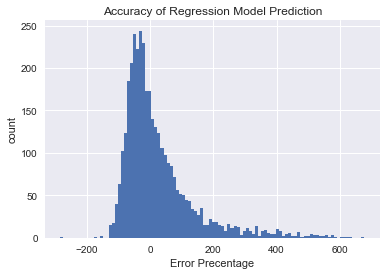

In [35]:
x = plt.hist(df.diff_ratio, bins = 100)
plt.xlabel('Error Precentage')
plt.ylabel('count')
plt.title('Accuracy of Regression Model Prediction')

In [36]:
mean_squared_error(df.reach, df.test_reach)**.5

6191.401810403435

In [37]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df["likes"].values.reshape(-1, 1)
comments = df["comments"].values.reshape(-1, 1)
followers = df["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df["reach"])
regression_2.fit(comments, df["reach"])
regression_3.fit(followers, df["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[7.85258507]
[79.36794599]
[0.21223753]


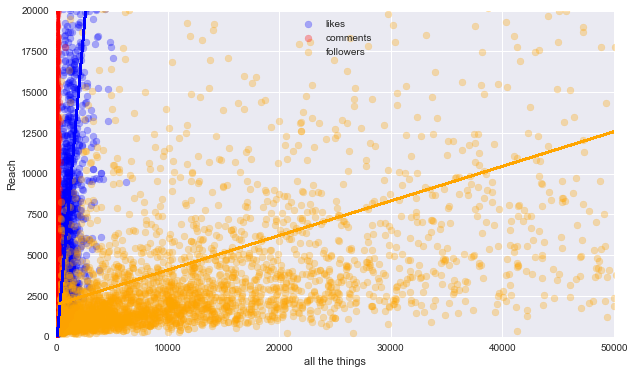

In [38]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df["reach"],  color='blue', alpha = 0.3, label = "likes")
plt.scatter(comments, df["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='orange', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.xlim(0,50000)
plt.ylim(0,20000)
plt.legend();

## Summary of the Group-By Trial

In this trial we found the mean of each users data first before determining the coefficients of the model. This lowered our Root Mean Sqaured Error in our accuracy ratio from an ungrouped set. However, our R-Squared has gone down. This Group-By trial had decent results but still not the accuracy we were hoping for. The plot of our correlation of followers to reach creates a view that doesn't suggest a correlation. 